# Global keypoint visualization

In [ ]:
import faiss
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# -------- Load FAISS index and metadata --------
FAISS_INDEX_PATH = "/home/spica/Projects/LangChain/data/faiss_index_qwen3_0.6B_Large/index.faiss"
FAISS_META_PATH = "/home/spica/Projects/LangChain/data/faiss_index_qwen3_0.6B_Large/meta.json"

# Load index
index = faiss.read_index(FAISS_INDEX_PATH)
print(f"Index loaded: {index.ntotal} vectors")

# Load metadata
with open(FAISS_META_PATH, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

assert len(metadata) == index.ntotal, "Metadata count and FAISS index entries mismatch!"

# -------- Extract vectors from index --------
vectors = np.array([index.reconstruct(i) for i in range(index.ntotal)])
print("Vector matrix shape:", vectors.shape)

# -------- Dimensionality Reduction --------
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)
print("Reduced shape:", reduced_vectors.shape)

# -------- Use metadata for coloring (e.g., by 'venue' or 'year') --------
# Choose grouping feature
color_field = "venue"  # You can also try "year"

color_labels = [meta.get(color_field, "unknown") for meta in metadata]
label_encoder = LabelEncoder()
color_values = label_encoder.fit_transform(color_labels)
unique_labels = label_encoder.classes_

# -------- Plot using matplotlib --------
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    reduced_vectors[:, 0],
    reduced_vectors[:, 1],
    c=color_values,
    cmap='tab20',
    alpha=0.7
)

plt.title(f"2D PCA of FAISS Vectors Colored by {color_field.capitalize()}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

# -------- Optional: create a legend --------
# Show up to 20 groups in legend to avoid clutter
max_legend_items = 20
handles = []
for i, label in enumerate(unique_labels[:max_legend_items]):
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              label=label, markersize=8, markerfacecolor=scatter.cmap(i / len(unique_labels))))
plt.legend(title=color_field.capitalize(), handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Index loaded: 386559 vectors
Vector matrix shape: (386559, 1024)


In [ ]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

print("Reduced shape:", reduced_vectors.shape)  # Should be (n, 2)

Reduced shape: (386605, 2)


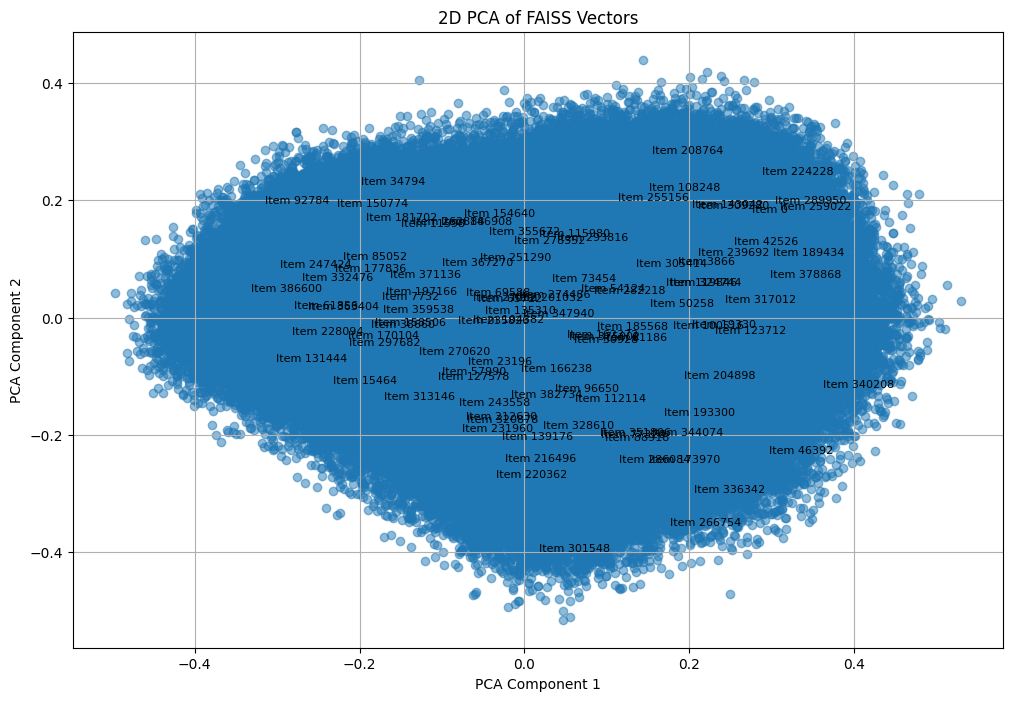

In [ ]:
plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)

# Optionally annotate every N points to avoid clutter
for i in range(0, len(labels), max(1, len(labels) // 100)):
    plt.annotate(labels[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

plt.title("2D PCA of FAISS Vectors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# Embedding and retrieval

In [ ]:
import os
# Set up DashScope-compatible Qwen model
os.environ["OPENAI_API_KEY"] = 'APPLY AT DASHSCOPE (QWEN3) or any other API you prefer'
os.environ["OPENAI_BASE_URL"] = "https://dashscope.aliyuncs.com/compatible-mode/v1"

In [ ]:
# === SECTION 1: INIT MODEL, TOKENIZER, FAISS ===

import os
import json
import faiss
import torch
import math
import numpy as np

from vllm import LLM, SamplingParams
from vllm.inputs.data import TokensPrompt
from transformers import AutoTokenizer
from langchain.chat_models import ChatOpenAI

# --- CONFIG ---


RERANKER_MODEL_PATH = "/mnt/sandisk/Qwen3-Reranker-0.6B"
EMBEDDING_MODEL_PATH = "/mnt/sandisk/Qwen3-Embedding-0.6B"
FAISS_INDEX_PATH = "/home/spica/Projects/LangChain/data/faiss_index_qwen3_0.6B_Large/index.faiss"
FAISS_META_PATH = "/home/spica/Projects/LangChain/data/faiss_index_qwen3_0.6B_Large/meta.json"

# --- Load FAISS index and metadata ---
index = faiss.read_index(FAISS_INDEX_PATH)
with open(FAISS_META_PATH, "r", encoding="utf-8") as f:
    metadata = json.load(f)

# --- Init embedding model (must be FIRST LLM call in kernel) ---
from vllm import LLM as EmbedLLM
embedder = EmbedLLM(model=EMBEDDING_MODEL_PATH, task="embed")  # task="embed" works if this is first call

# --- Init reranker ---
tokenizer = AutoTokenizer.from_pretrained(RERANKER_MODEL_PATH)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
suffix_tokens = tokenizer.encode(suffix, add_special_tokens=False)
true_token = tokenizer("yes", add_special_tokens=False).input_ids[0]
false_token = tokenizer("no", add_special_tokens=False).input_ids[0]

rerank_model = LLM(
    model=RERANKER_MODEL_PATH,
    tensor_parallel_size=1,
    max_model_len=8192,
    enable_prefix_caching=True,
    gpu_memory_utilization=0.8
)

sampling_params = SamplingParams(
    temperature=0,
    max_tokens=1,
    logprobs=20,
    allowed_token_ids=[true_token, false_token],
)

llm = ChatOpenAI(
    model="qwen-plus",
    temperature=0.3,
    openai_api_base=os.environ["OPENAI_BASE_URL"]
)

# --- Helper functions ---
def format_instruction(task, query, doc):
    return [
        {"role": "system", "content": "Judge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\"."},
        {"role": "user", "content": f"<Instruct>: {task}\n\n<Query>: {query}\n\n<Document>: {doc}"}
    ]

def build_rerank_inputs(pairs, task, max_len, suffix_tokens):
    messages = [format_instruction(task, q, d) for q, d in pairs]
    tokenized = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=False, enable_thinking=False)
    tokenized = [m[:max_len] + suffix_tokens for m in tokenized]
    return [TokensPrompt(prompt_token_ids=t) for t in tokenized]

def compute_rerank_scores(inputs):
    outputs = rerank_model.generate(inputs, sampling_params, use_tqdm=False)
    scores = []
    for out in outputs:
        logits = out.outputs[0].logprobs[-1]
        true_logprob = logits.get(true_token, None)
        false_logprob = logits.get(false_token, None)
        t_val = math.exp(true_logprob.logprob) if true_logprob else math.exp(-10)
        f_val = math.exp(false_logprob.logprob) if false_logprob else math.exp(-10)
        scores.append(t_val / (t_val + f_val))
    return scores

/mnt/sandisk/miniconda3/envs/rag-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 08-21 14:02:31 [__init__.py:244] Automatically detected platform cuda.


2025-08-21 14:02:34,127	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 08-21 14:02:51 [config.py:484] Found sentence-transformers modules configuration.
INFO 08-21 14:02:51 [config.py:504] Found pooling configuration.
WARNING 08-21 14:02:51 [arg_utils.py:1642] --task embed is not supported by the V1 Engine. Falling back to V0. 
INFO 08-21 14:02:51 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.1) with config: model='/mnt/sandisk/Qwen3-Embedding-0.6B', speculative_config=None, tokenizer='/mnt/sandisk/Qwen3-Embedding-0.6B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.68it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.66it/s]


INFO 08-21 14:02:55 [default_loader.py:272] Loading weights took 0.31 seconds


INFO 08-21 14:02:56 [model_runner.py:1203] Model loading took 1.1177 GiB and 0.475043 seconds
INFO 08-21 14:02:57 [config.py:823] This model supports multiple tasks: {'classify', 'score', 'reward', 'embed', 'generate'}. Defaulting to 'generate'.
INFO 08-21 14:02:57 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.1) with config: model='/mnt/sandisk/Qwen3-Reranker-0.6B', speculative_config=None, tokenizer='/mnt/sandisk/Qwen3-Reranker-0.6B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observa

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.55it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.54it/s]


INFO 08-21 14:02:59 [default_loader.py:272] Loading weights took 0.33 seconds


INFO 08-21 14:03:00 [model_runner.py:1203] Model loading took 1.1196 GiB and 0.402003 seconds
INFO 08-21 14:03:02 [worker.py:294] Memory profiling takes 0.95 seconds
INFO 08-21 14:03:02 [worker.py:294] the current vLLM instance can use total_gpu_memory (23.56GiB) x gpu_memory_utilization (0.80) = 18.85GiB
INFO 08-21 14:03:02 [worker.py:294] model weights take 1.12GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 1.40GiB; the rest of the memory reserved for KV Cache is 16.31GiB.
INFO 08-21 14:03:02 [executor_base.py:113] # cuda blocks: 9545, # CPU blocks: 2340
INFO 08-21 14:03:02 [executor_base.py:118] Maximum concurrency for 8192 tokens per request: 18.64x
INFO 08-21 14:03:05 [model_runner.py:1513] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decre

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:40<00:00,  1.16s/it]

INFO 08-21 14:03:46 [model_runner.py:1671] Graph capturing finished in 41 secs, took 0.23 GiB
INFO 08-21 14:03:46 [llm_engine.py:428] init engine (profile, create kv cache, warmup model) took 45.64 seconds



/tmp/ipykernel_690099/2897871924.py:57: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


## Summarize with LLM API

In [ ]:
### KEY QUERRY ###
QUERY = "Give me a academic review on LoRA fine-tune LLM with time-series data"
### KEY QUERRY ###

TASK = "Given a web search query, retrieve relevant passages that answer the query"
TOP_K = 100
TOP_K_FINAL = 20

# --- Embed query ---
query_emb = embedder.embed([QUERY])[0].outputs.embedding
query_emb = np.array(query_emb).astype(np.float32).reshape(1, -1)

# --- FAISS search ---
_, top_idxs = index.search(query_emb, TOP_K)
candidates = [metadata[i] for i in top_idxs[0]]
candidate_texts = [c["text"] for c in candidates]
pairs = [(QUERY, doc) for doc in candidate_texts]

# --- Rerank ---
rerank_inputs = build_rerank_inputs(pairs, TASK, 8192 - len(suffix_tokens), suffix_tokens)
scores = compute_rerank_scores(rerank_inputs)
ranked = sorted(zip(scores, candidates), key=lambda x: -x[0])[:TOP_K_FINAL]
reranked_texts = ['「'+x[1]["title"]+'」('+x[1]["year"] +'):'+x[1]["text"] for x in ranked]

# --- Generate final response ---
context = "\n\n".join([f"[{i+1}] {chunk}" for i, chunk in enumerate(reranked_texts)])
final_prompt = f"""Given the following context:\n\n{context}\n\nAnswer the user query:\n{QUERY}"""

### INVOKE LLM API ###
res = llm.invoke(final_prompt)
print(res.content)

# Trend Visualization

Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Found 1000 valid candidates out of 1000 retrieved indices
Total entries in metadata for included venues: 389097


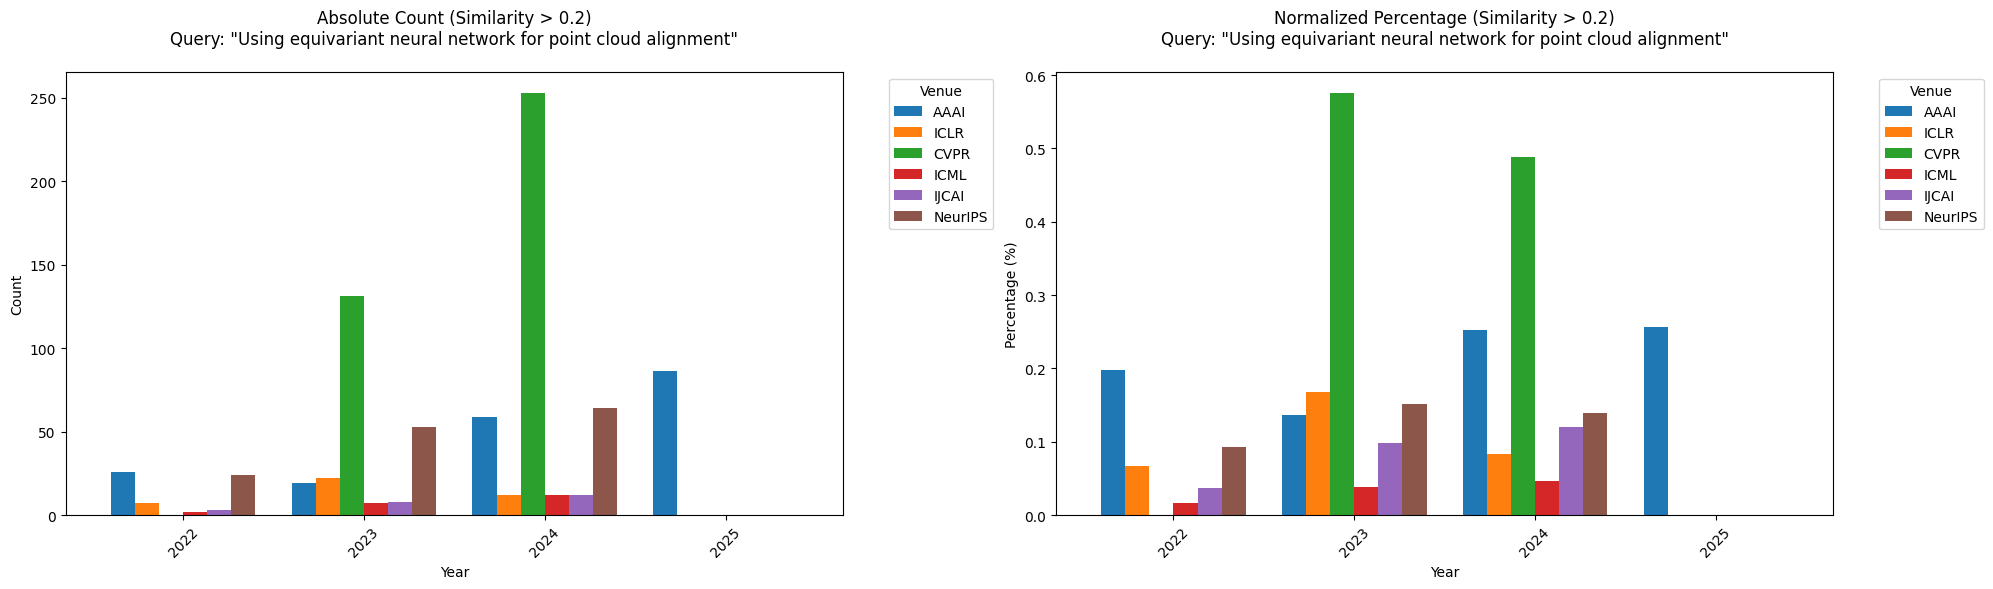


SUMMARY FOR QUERY: 'Using equivariant neural network for point cloud alignment'

Venue order (by conference month):
  AAAI: February
  ICLR: April/May
  CVPR: June
  ACL: July
  ICML: July
  IJCAI: August
  NeurIPS: December

Basic Statistics:
  Total entries with similarity > 0.2: 800
  Score range: 0.3087 to 0.6351
  Years represented: ['2022', '2023', '2024', '2025']
  Venues represented: ['AAAI', 'CVPR', 'ICLR', 'ICML', 'IJCAI', 'NeurIPS']

Detailed Breakdown (Retrieved / Total = Percentage):
  2022:
    AAAI:  26/13123 =  0.20%
    ICLR:   7/10561 =  0.07%
    ICML:   2/12240 =  0.02%
    IJCAI:   3/8273 =  0.04%
    NeurIPS:  24/25710 =  0.09%
  2023:
    AAAI:  19/13949 =  0.14%
    ICLR:  22/13153 =  0.17%
    CVPR: 131/22745 =  0.58%
    ICML:   7/18150 =  0.04%
    IJCAI:   8/8194 =  0.10%
    NeurIPS:  53/35017 =  0.15%
  2024:
    AAAI:  59/23374 =  0.25%
    ICLR:  12/14485 =  0.08%
    CVPR: 253/51844 =  0.49%
    ICML:  12/25928 =  0.05%
    IJCAI:  12/10011 =  0.12%
  

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

# =============================================================================
# CONFIGURATION
# =============================================================================

# Query settings
TASK = "Given a web search query, retrieve relevant passages that answer the query"
QUERY = "Using equivariant neural network for point cloud alignment"

# Search parameters
TOP_K = 1000
TOP_K_FINAL = 800
SIMILARITY_THRESHOLD = 0.2

# Venues ordered by typical conference month
VENUE_ORDER = ['AAAI', 'ICLR', 'CVPR', 'ACL', 'ICML', 'IJCAI', 'NeurIPS']
VENUE_MONTHS = {
    'AAAI': 'February',
    'ICLR': 'April/May', 
    'CVPR': 'June',
    'ACL': 'July',
    'ICML': 'July',
    'IJCAI': 'August',
    'NeurIPS': 'December'
}
INCLUDED_VENUES = set(VENUE_ORDER)

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def search_faiss_index(query, embedder, index, top_k):
    """Search FAISS index and return valid candidates with scores."""
    # Embed query
    query_emb = embedder.embed([query])[0].outputs.embedding
    query_emb = np.array(query_emb).astype(np.float32).reshape(1, -1)
    
    # FAISS search
    distances, top_idxs = index.search(query_emb, top_k)
    
    # Filter valid indices
    candidates, scores, valid_indices = [], [], []
    for idx, distance in zip(top_idxs[0], distances[0]):
        if 0 <= idx < len(metadata):
            candidates.append(metadata[idx])
            scores.append(1 - distance)  # Convert distance to similarity
            valid_indices.append(idx)
        else:
            print(f"Warning: Index {idx} out of range (metadata length: {len(metadata)}), skipping...")
    
    print(f"Found {len(candidates)} valid candidates out of {len(top_idxs[0])} retrieved indices")
    return candidates, scores, valid_indices

def count_entries_by_venue_year(entries, venues=None):
    """Count entries by venue and year, optionally filtering by venues."""
    counts = defaultdict(lambda: defaultdict(int))
    for entry in entries:
        venue = entry.get('venue', 'Unknown')
        year = entry.get('year', 'Unknown')
        if venues is None or venue in venues:
            counts[year][venue] += 1
    return counts

def filter_high_similarity_entries(ranked_entries, threshold, venues):
    """Filter entries above similarity threshold and in specified venues."""
    return [
        (score, entry) for score, entry in ranked_entries 
        if score > threshold and entry.get('venue') in venues
    ]

def create_plot_data(retrieved_counts, total_counts):
    """Create plot data with absolute and normalized counts."""
    plot_data = []
    for year, venue_counts in retrieved_counts.items():
        for venue, count in venue_counts.items():
            total_count = total_counts[year][venue]
            normalized_count = count / total_count if total_count > 0 else 0
            plot_data.append({
                'year': year, 
                'venue': venue, 
                'count': count,
                'total_count': total_count,
                'normalized_count': normalized_count
            })
    return plot_data

def create_visualization(plot_data, query, threshold, venue_order):
    """Create side-by-side absolute and normalized bar plots."""
    if not plot_data:
        print(f"No entries found with similarity > {threshold} for query: '{query}' in selected venues")
        return
    
    df = pd.DataFrame(plot_data)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Absolute counts plot
    pivot_abs = df.pivot(index='year', columns='venue', values='count').fillna(0)
    pivot_abs = pivot_abs.sort_index().reindex(columns=[v for v in venue_order if v in pivot_abs.columns])
    
    pivot_abs.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title(f'Absolute Count (Similarity > {threshold})\nQuery: "{query}"', fontsize=12, pad=20)
    ax1.set_xlabel('Year', fontsize=10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.legend(title='Venue', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Normalized percentage plot
    pivot_norm = df.pivot(index='year', columns='venue', values='normalized_count').fillna(0)
    pivot_norm = pivot_norm.sort_index().reindex(columns=[v for v in venue_order if v in pivot_norm.columns])
    pivot_norm_pct = pivot_norm * 100
    
    pivot_norm_pct.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title(f'Normalized Percentage (Similarity > {threshold})\nQuery: "{query}"', fontsize=12, pad=20)
    ax2.set_xlabel('Year', fontsize=10)
    ax2.set_ylabel('Percentage (%)', fontsize=10)
    ax2.legend(title='Venue', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def print_summary_statistics(query, high_similarity_entries, scores, retrieved_counts, 
                           total_counts, venue_order, venue_months, threshold):
    """Print comprehensive summary statistics."""
    print(f"\n" + "="*80)
    print(f"SUMMARY FOR QUERY: '{query}'")
    print(f"="*80)
    
    # Venue information
    print(f"\nVenue order (by conference month):")
    for venue in venue_order:
        print(f"  {venue}: {venue_months[venue]}")
    
    # Basic statistics
    print(f"\nBasic Statistics:")
    print(f"  Total entries with similarity > {threshold}: {len(high_similarity_entries)}")
    print(f"  Score range: {min(scores):.4f} to {max(scores):.4f}")
    print(f"  Years represented: {sorted(list(retrieved_counts.keys()))}")
    print(f"  Venues represented: {sorted(set(venue for venue_counts in retrieved_counts.values() for venue in venue_counts.keys()))}")
    
    # Detailed breakdown
    print(f"\nDetailed Breakdown (Retrieved / Total = Percentage):")
    for year in sorted(retrieved_counts.keys()):
        print(f"  {year}:")
        for venue in venue_order:
            if venue in retrieved_counts[year]:
                count = retrieved_counts[year][venue]
                total = total_counts[year][venue]
                percentage = (count / total * 100) if total > 0 else 0
                print(f"    {venue}: {count:3d}/{total:3d} = {percentage:5.2f}%")

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    # Search and retrieve candidates
    candidates, scores, valid_indices = search_faiss_index(QUERY, embedder, index, TOP_K)
    
    if len(candidates) == 0:
        print("No valid candidates found. Please check your FAISS index and metadata alignment.")
        return
    
    # Get top candidates (no re-ranking)
    ranked = list(zip(scores, candidates))[:TOP_K_FINAL]
    
    # Filter high similarity entries
    high_similarity_entries = filter_high_similarity_entries(ranked, SIMILARITY_THRESHOLD, INCLUDED_VENUES)
    
    # Count entries
    total_counts = count_entries_by_venue_year(metadata, INCLUDED_VENUES)
    retrieved_counts = count_entries_by_venue_year([entry for _, entry in high_similarity_entries])
    
    # Print total metadata statistics
    total_entries = sum(sum(venue_counts.values()) for venue_counts in total_counts.values())
    print(f"Total entries in metadata for included venues: {total_entries}")
    
    # Create visualization
    plot_data = create_plot_data(retrieved_counts, total_counts)
    create_visualization(plot_data, QUERY, SIMILARITY_THRESHOLD, VENUE_ORDER)
    
    # Print summary
    print_summary_statistics(QUERY, high_similarity_entries, scores, retrieved_counts, 
                           total_counts, VENUE_ORDER, VENUE_MONTHS, SIMILARITY_THRESHOLD)
    
    # Generate context for LLM (optional)
    reranked_texts = [f'「{entry["title"]}」({entry["year"]}): {entry["text"]}' for _, entry in ranked]
    context = "\n\n".join([f"[{i+1}] {chunk}" for i, chunk in enumerate(reranked_texts)])
    final_prompt = f"Given the following context:\n\n{context}\n\nAnswer the user query:\n{QUERY}"
    
    # Uncomment to use with LLM:
    # res = llm.invoke(final_prompt)
    # print(res.content)

# Run the analysis
if __name__ == "__main__":
    main()

# Example of retrieved keypoint

In [9]:
metadata[30]

{'file': '[NeurIPS 2022]Deliberated Domain Bridging for Domain Adaptive Semantic Segmentation_f54e7434.json',
 'index': 5,
 'text': 'DDB achieves state-of-the-art performance on GTA5→Cityscapes, GTA5+Synscapes→Cityscapes, and GTA5→Cityscapes+Mapillary benchmarks. It outperforms methods like ProDA, ADVENT, and CPSL by significant margins, particularly in handling class bias and multi-domain adaptation scenarios.',
 'title': 'Deliberated Domain Bridging for Domain Adaptive Semantic Segmentation',
 'authors': 'Lin Chen, Zhixiang Wei, Xin Jin, Huaian Chen, Miao Zheng, Kai Chen, Yi Jin',
 'year': '2022',
 'venue': 'NeurIPS',
 'field': ['Computer Vision', 'Domain Adaptation', 'Semantic Segmentation'],
 'first_author_affiliation': 'University of Science and Technology of China'}

# Year by year field trend

Processed 1167129 valid entries, skipped 84 invalid entries

DATA SUMMARY (2022+)
Total papers: 1167129
Unique fields: 16870
Years: [2022, 2023, 2024, 2025]

Papers per year:
  2022: 209778 papers
  2023: 333654 papers
  2024: 515472 papers
  2025: 108225 papers

ANALYZING SPECIFIED FIELDS
Plotting 10 fields from Specified Fields


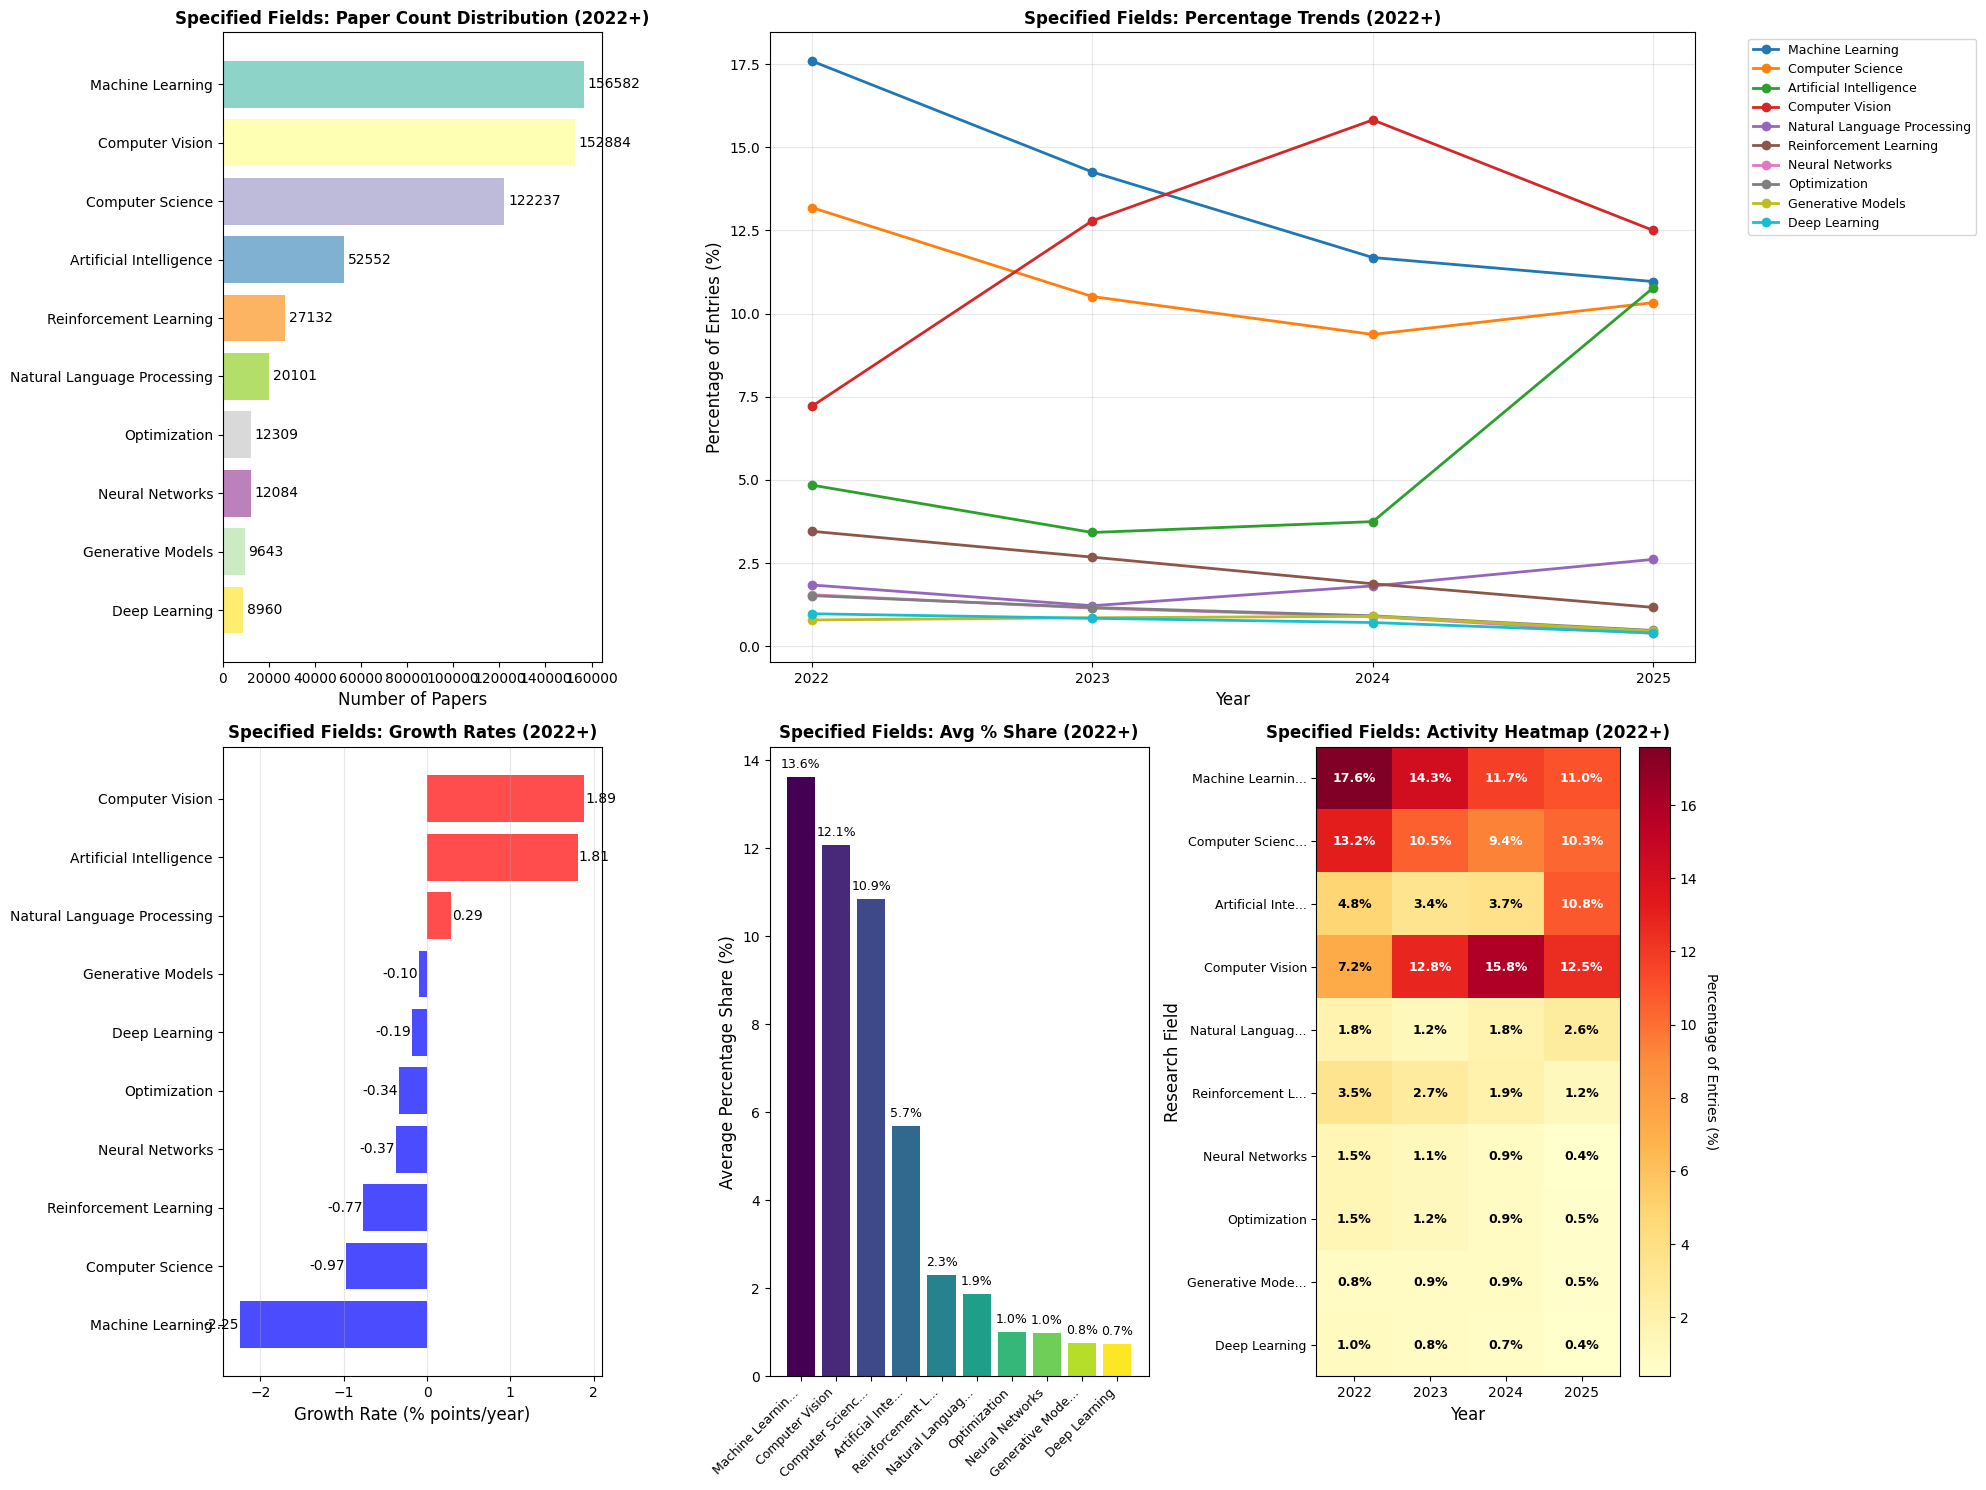


ANALYZING TOP 40 REMAINING FIELDS
Plotting 40 fields from Top 40 Remaining Fields


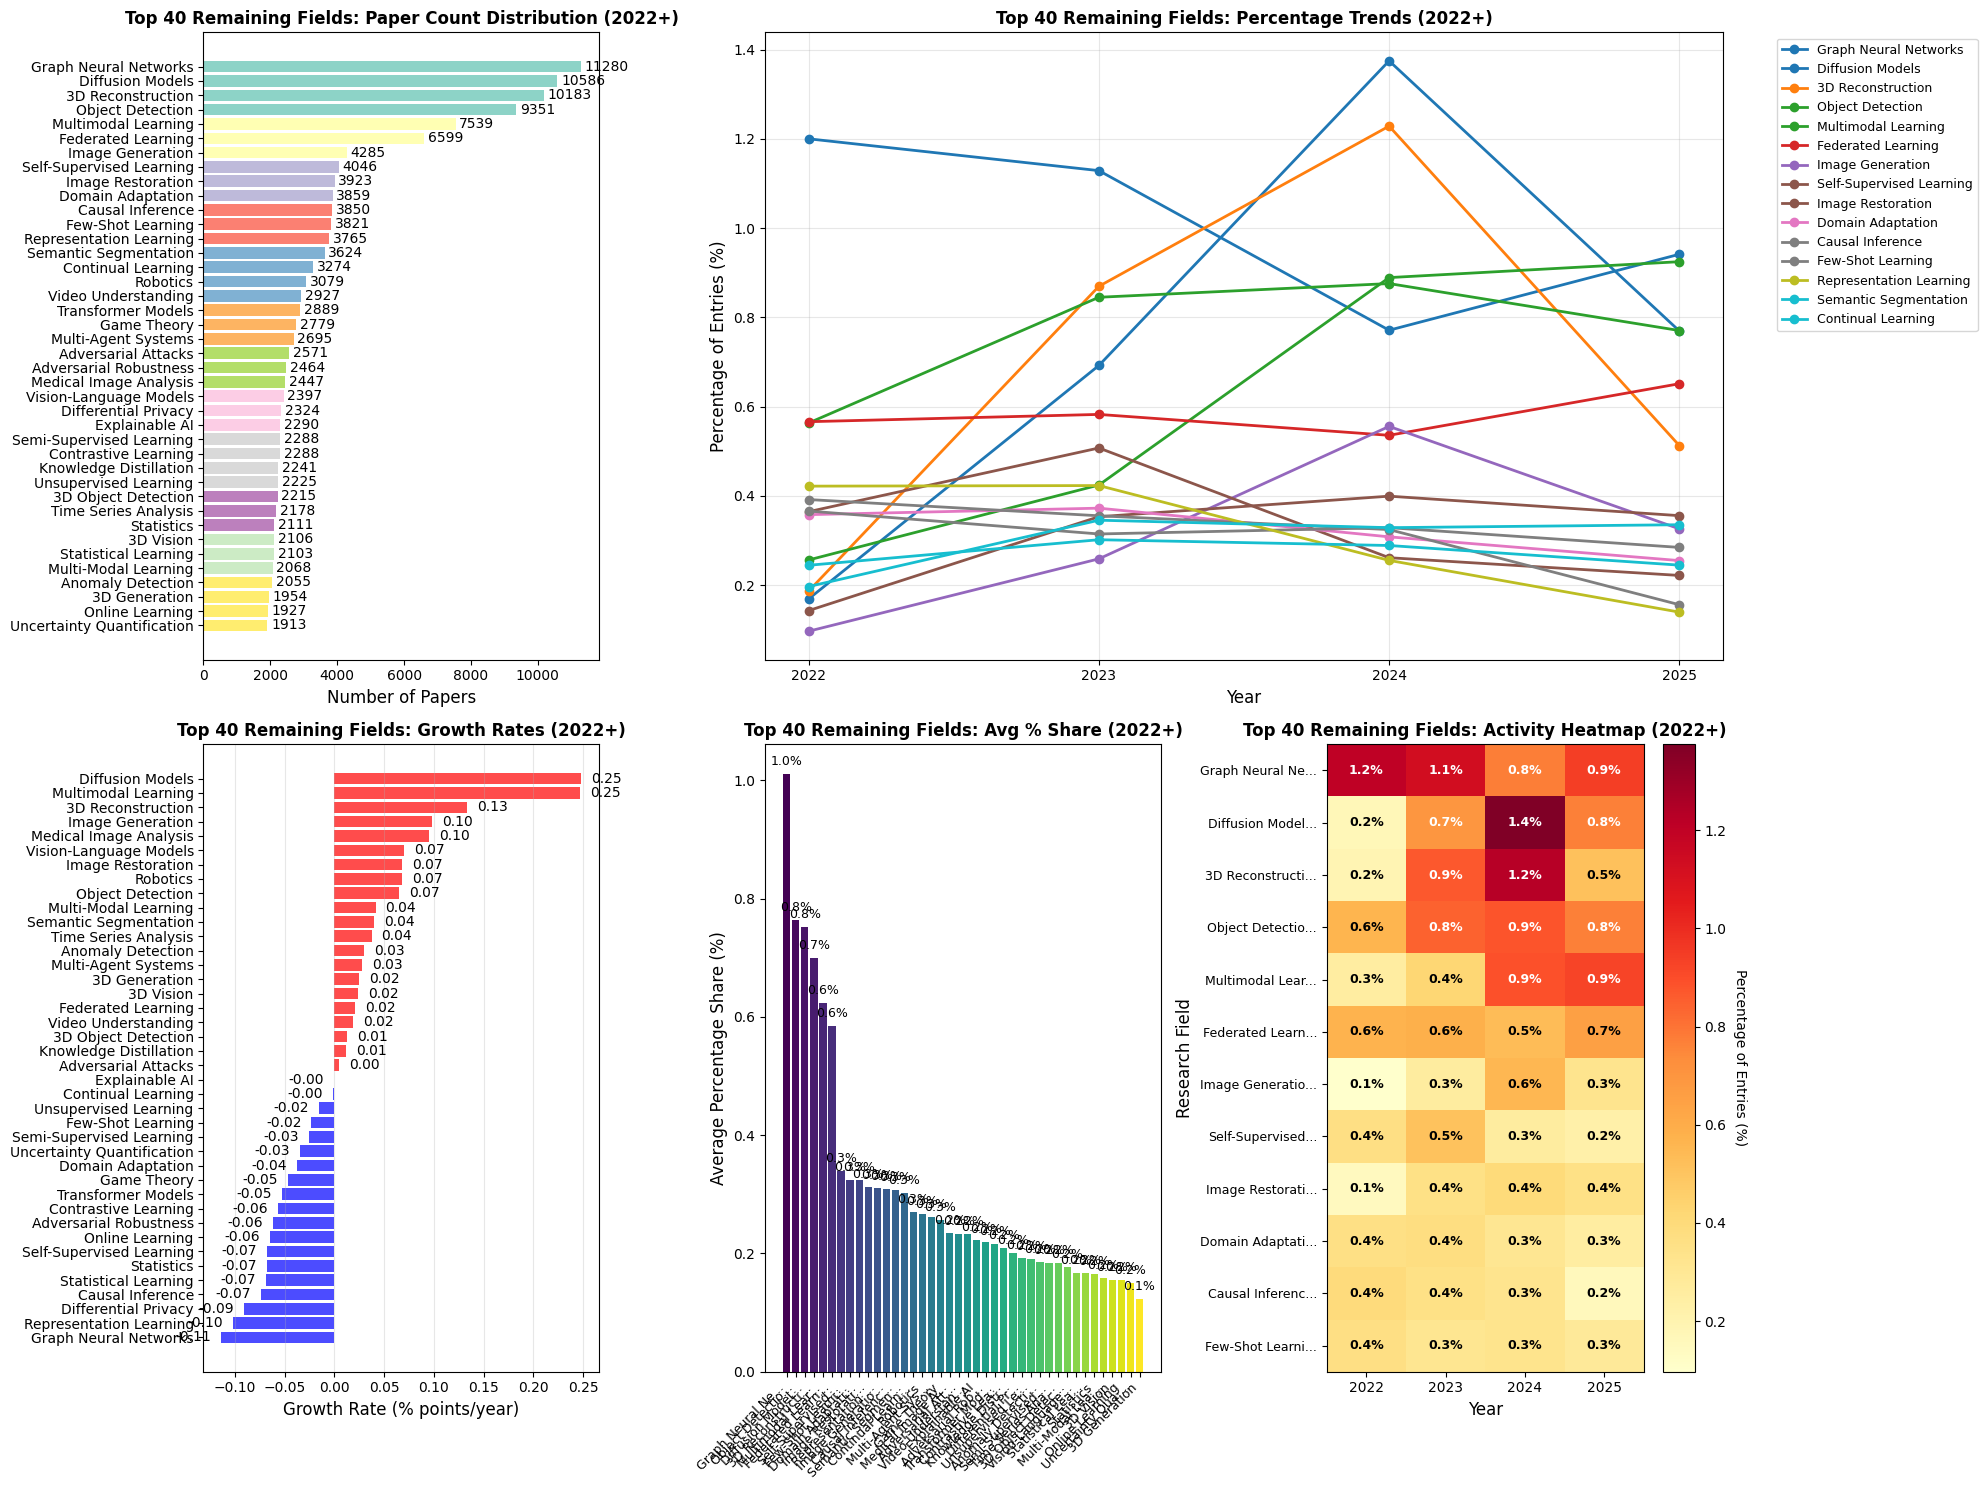

SPECIFIED FIELDS ANALYSIS
Fields analyzed: 10
Time period: 2022-2025

Growth rates (percentage points per year):
--------------------------------------------------
 1. Computer Vision
    Growth Rate: +1.89 pp/year
    Total Papers: 152884
    Avg % Share: 12.1%

 2. Artificial Intelligence
    Growth Rate: +1.81 pp/year
    Total Papers: 52552
    Avg % Share: 5.7%

 3. Natural Language Processing
    Growth Rate: +0.29 pp/year
    Total Papers: 20101
    Avg % Share: 1.9%

 4. Generative Models
    Growth Rate: -0.10 pp/year
    Total Papers: 9643
    Avg % Share: 0.8%

 5. Deep Learning
    Growth Rate: -0.19 pp/year
    Total Papers: 8960
    Avg % Share: 0.7%

 6. Optimization
    Growth Rate: -0.34 pp/year
    Total Papers: 12309
    Avg % Share: 1.0%

 7. Neural Networks
    Growth Rate: -0.37 pp/year
    Total Papers: 12084
    Avg % Share: 1.0%

 8. Reinforcement Learning
    Growth Rate: -0.77 pp/year
    Total Papers: 27132
    Avg % Share: 2.3%

 9. Computer Science
    Gro

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class ResearchFieldAnalyzer:
    """A class to analyze research field trends from metadata."""
    
    def __init__(self, start_year=2022):
        self.start_year = start_year
        self.df = None
        self.field_year_counts = None
        self.field_year_ratios = None
    
    def load_and_process_data(self, metadata_list):
        """Load and process metadata into DataFrames."""
        field_year_data = []
        skipped_items = 0
        
        for item in metadata_list:
            try:
                year = int(item['year'])
                if year < self.start_year:
                    skipped_items += 1
                    continue
            except (ValueError, TypeError):
                skipped_items += 1
                continue
            
            fields = item['field']
            if isinstance(fields, str):
                fields = [fields]
            elif fields is None:
                skipped_items += 1
                continue
            
            for field in fields:
                if field and isinstance(field, str):
                    field_year_data.append({
                        'field': field.strip(),
                        'year': year
                    })
        
        print(f"Processed {len(field_year_data)} valid entries, skipped {skipped_items} invalid entries")
        
        # Create DataFrames
        self.df = pd.DataFrame(field_year_data)
        if self.df.empty:
            print("No valid data found!")
            return False
        
        self.field_year_counts = self.df.groupby(['year', 'field']).size().unstack(fill_value=0)
        self.field_year_ratios = self.field_year_counts.div(
            self.field_year_counts.sum(axis=1), axis=0
        ) * 100
        
        return True
    
    def calculate_growth_rates(self, fields):
        """Calculate growth rates for specified fields."""
        growth_rates = {}
        
        for field in fields:
            if field not in self.field_year_ratios.columns:
                growth_rates[field] = 0
                continue
            
            field_data = self.field_year_ratios[field]
            years = field_data.index.values
            ratios = field_data.values
            
            non_zero_mask = ratios > 0
            if np.sum(non_zero_mask) < 2:
                growth_rates[field] = 0
                continue
            
            years_nz = years[non_zero_mask]
            ratios_nz = ratios[non_zero_mask]
            
            if len(years_nz) >= 2:
                try:
                    slope, _, _, _, _ = stats.linregress(years_nz, ratios_nz)
                    growth_rates[field] = slope
                except:
                    growth_rates[field] = 0
            else:
                growth_rates[field] = 0
        
        return growth_rates
    
    def _setup_subplot_layout(self, figsize=(20, 15)):
        """Create and return figure with standard subplot layout."""
        fig = plt.figure(figsize=figsize)
        axes = {
            'distribution': plt.subplot(2, 3, 1),
            'trends': plt.subplot(2, 3, (2, 3)),
            'growth': plt.subplot(2, 3, 4),
            'average': plt.subplot(2, 3, 5),
            'heatmap': plt.subplot(2, 3, 6)
        }
        return fig, axes
    
    def _plot_distribution(self, ax, fields, title_prefix):
        """Plot horizontal bar chart of paper counts."""
        field_totals = self.df[self.df['field'].isin(fields)]['field'].value_counts()
        if len(field_totals) == 0:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            return
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(field_totals)))
        bars = ax.barh(range(len(field_totals)), field_totals.values, color=colors)
        ax.set_yticks(range(len(field_totals)))
        ax.set_yticklabels(field_totals.index, fontsize=10)
        ax.set_xlabel('Number of Papers', fontsize=12)
        ax.set_title(f'{title_prefix}: Paper Count Distribution ({self.start_year}+)', 
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        
        # Add value labels
        max_val = max(field_totals.values) if len(field_totals.values) > 0 else 1
        for bar, value in zip(bars, field_totals.values):
            ax.text(bar.get_width() + max_val * 0.01, 
                   bar.get_y() + bar.get_height()/2, 
                   str(value), ha='left', va='center', fontsize=10)
    
    def _plot_trends(self, ax, fields, title_prefix, max_lines=None):
        """Plot percentage trends over time."""
        existing_fields = [f for f in fields if f in self.field_year_ratios.columns]
        
        # Use max_lines if provided, otherwise show all fields
        if max_lines is not None:
            existing_fields = existing_fields[:max_lines]
        
        if not existing_fields:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            return
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(existing_fields)))
        
        for i, field in enumerate(existing_fields):
            field_data = self.field_year_ratios[field]
            ax.plot(field_data.index, field_data.values, marker='o', 
                   linewidth=2, label=field, markersize=6, color=colors[i])
        
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Percentage of Entries (%)', fontsize=12)
        ax.set_title(f'{title_prefix}: Percentage Trends ({self.start_year}+)', 
                    fontsize=12, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        years = sorted(self.df['year'].unique())
        ax.set_xticks(years)
    
    def _plot_growth_rates(self, ax, fields, title_prefix):
        """Plot growth rates as horizontal bar chart."""
        growth_rates = self.calculate_growth_rates(fields)
        
        if not growth_rates or all(rate == 0 for rate in growth_rates.values()):
            ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)
            return growth_rates
        
        sorted_growth = sorted(growth_rates.items(), key=lambda x: x[1], reverse=True)
        fields_sorted = [item[0] for item in sorted_growth]
        rates_sorted = [item[1] for item in sorted_growth]
        
        colors = ['red' if rate > 0 else 'blue' for rate in rates_sorted]
        bars = ax.barh(range(len(fields_sorted)), rates_sorted, color=colors, alpha=0.7)
        ax.set_yticks(range(len(fields_sorted)))
        ax.set_yticklabels(fields_sorted, fontsize=10)
        ax.set_xlabel('Growth Rate (% points/year)', fontsize=12)
        ax.set_title(f'{title_prefix}: Growth Rates ({self.start_year}+)', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.invert_yaxis()
        
        # Add value labels
        for bar, rate in zip(bars, rates_sorted):
            ax.text(bar.get_width() + (0.01 if rate > 0 else -0.01), 
                   bar.get_y() + bar.get_height()/2, 
                   f'{rate:.2f}', ha='left' if rate > 0 else 'right', va='center', fontsize=10)
        
        return growth_rates
    
    def _plot_average_share(self, ax, fields, title_prefix, max_fields=None):
        """Plot average percentage share."""
        existing_fields = [f for f in fields if f in self.field_year_ratios.columns]
        if not existing_fields:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            return
        
        avg_percentages = self.field_year_ratios[existing_fields].mean().sort_values(ascending=False)
        
        # Use max_fields if provided, otherwise show all fields
        if max_fields is not None:
            avg_percentages = avg_percentages.head(max_fields)
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(avg_percentages)))
        bars = ax.bar(range(len(avg_percentages)), avg_percentages.values, color=colors)
        
        labels = [field[:15] + '...' if len(field) > 15 else field for field in avg_percentages.index]
        ax.set_xticks(range(len(avg_percentages)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Average Percentage Share (%)', fontsize=12)
        ax.set_title(f'{title_prefix}: Avg % Share ({self.start_year}+)', 
                    fontsize=12, fontweight='bold')
        
        # Add value labels
        max_val = max(avg_percentages.values) if len(avg_percentages.values) > 0 else 1
        for bar, value in zip(bars, avg_percentages.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_val * 0.01, 
                   f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
    
    def _plot_heatmap(self, ax, fields, title_prefix, max_fields=None):
        """Plot activity heatmap."""
        existing_fields = [f for f in fields if f in self.field_year_ratios.columns]
        
        # Use max_fields if provided, otherwise show all fields
        if max_fields is not None:
            existing_fields = existing_fields[:max_fields]
        
        if not existing_fields:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            return
        
        heatmap_data = self.field_year_ratios[existing_fields].T
        im = ax.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
        
        ax.set_xticks(range(len(heatmap_data.columns)))
        ax.set_xticklabels(heatmap_data.columns)
        ax.set_yticks(range(len(heatmap_data.index)))
        
        labels = [field[:15] + '...' if len(field) > 15 else field for field in heatmap_data.index]
        ax.set_yticklabels(labels, fontsize=9)
        
        # Add text annotations
        for i in range(len(heatmap_data.index)):
            for j in range(len(heatmap_data.columns)):
                value = heatmap_data.iloc[i, j]
                text_color = "white" if value > heatmap_data.values.max()/2 else "black"
                ax.text(j, i, f'{value:.1f}%', ha="center", va="center", 
                       color=text_color, fontweight='bold', fontsize=9)
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Percentage of Entries (%)', rotation=270, labelpad=15)
        
        ax.set_title(f'{title_prefix}: Activity Heatmap ({self.start_year}+)', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Research Field', fontsize=12)
    
    def plot_field_analysis(self, fields, title_prefix="Fields", max_display_fields=None):
        """Create comprehensive analysis plots for specified fields.
        
        Args:
            fields: List of field names to analyze
            title_prefix: Prefix for plot titles
            max_display_fields: Maximum number of fields to display in plots (None = show all)
        """
        if self.df is None or self.df.empty:
            print("No data available for plotting!")
            return {}
        
        existing_fields = [f for f in fields if f in self.field_year_ratios.columns]
        missing_fields = [f for f in fields if f not in self.field_year_ratios.columns]
        
        if missing_fields:
            print(f"Warning: Missing fields in data: {missing_fields}")
        
        if not existing_fields:
            print("None of the specified fields were found!")
            return {}
        
        print(f"Plotting {len(existing_fields)} fields from {title_prefix}")
        
        # Determine display limits
        if max_display_fields is None:
            max_display_fields = len(existing_fields)
        
        # Adaptive limits for different plot types
        trends_limit = min(15, max_display_fields)  # Max 15 for readability
        heatmap_limit = min(12, max_display_fields)  # Max 12 for heatmap visibility
        average_limit = max_display_fields  # Can show all for bar chart
        
        fig, axes = self._setup_subplot_layout()
        
        self._plot_distribution(axes['distribution'], existing_fields, title_prefix)
        self._plot_trends(axes['trends'], existing_fields, title_prefix, max_lines=trends_limit)
        growth_rates = self._plot_growth_rates(axes['growth'], existing_fields, title_prefix)
        self._plot_average_share(axes['average'], existing_fields, title_prefix, max_fields=average_limit)
        self._plot_heatmap(axes['heatmap'], existing_fields, title_prefix, max_fields=heatmap_limit)
        
        plt.tight_layout()
        plt.show()
        
        return growth_rates
    
    def print_field_summary(self, fields, growth_rates, title):
        """Print detailed summary statistics."""
        print("=" * 80)
        print(f"{title.upper()}")
        print("=" * 80)
        
        existing_fields = [f for f in fields if f in self.field_year_ratios.columns]
        if not existing_fields:
            print("No fields found in the data!")
            return
        
        sorted_growth = sorted([(f, growth_rates.get(f, 0)) for f in existing_fields], 
                              key=lambda x: x[1], reverse=True)
        
        print(f"Fields analyzed: {len(existing_fields)}")
        print(f"Time period: {self.df['year'].min()}-{self.df['year'].max()}")
        print(f"\nGrowth rates (percentage points per year):")
        print("-" * 50)
        
        for i, (field, rate) in enumerate(sorted_growth, 1):
            field_papers = self.df[self.df['field'] == field]
            total_papers = len(field_papers)
            avg_ratio = self.field_year_ratios[field].mean()
            
            print(f"{i:2d}. {field}")
            print(f"    Growth Rate: {rate:+.2f} pp/year")
            print(f"    Total Papers: {total_papers}")
            print(f"    Avg % Share: {avg_ratio:.1f}%")
            print()
    
    def get_data_summary(self):
        """Print overall data summary."""
        if self.df is None or self.df.empty:
            print("No data loaded!")
            return
        
        print(f"\nDATA SUMMARY ({self.start_year}+)")
        print("=" * 50)
        print(f"Total papers: {len(self.df)}")
        print(f"Unique fields: {self.df['field'].nunique()}")
        print(f"Years: {sorted(self.df['year'].unique())}")
        
        yearly_counts = self.df['year'].value_counts().sort_index()
        print(f"\nPapers per year:")
        for year, count in yearly_counts.items():
            print(f"  {year}: {count} papers")

def main(metadata_list, remaining_fields_count=20):
    """Main function to run the complete analysis.
    
    Args:
        metadata_list: List of metadata dictionaries
        remaining_fields_count: Number of top remaining fields to analyze (default: 20)
    """
    # Initialize analyzer
    analyzer = ResearchFieldAnalyzer(start_year=2022)
    
    # Load and process data
    if not analyzer.load_and_process_data(metadata_list):
        return
    
    # Print data summary
    analyzer.get_data_summary()
    
    # Define field groups
    specified_fields = [
        'Machine Learning', 
        'Computer Science', 
        'Artificial Intelligence',
        'Computer Vision',
         'Natural Language Processing', 'Reinforcement Learning',
        'Neural Networks', 'Optimization', 'Generative Models', 'Deep Learning'
    ]
    
    # Get remaining top fields
    all_field_counts = analyzer.df['field'].value_counts()
    remaining_fields = [field for field in all_field_counts.head(remaining_fields_count).index 
                       if field not in specified_fields]
    
    # Analyze specified fields
    print(f"\n{'='*60}")
    print("ANALYZING SPECIFIED FIELDS")
    print(f"{'='*60}")
    specified_growth = analyzer.plot_field_analysis(
        specified_fields, 
        "Specified Fields",
        max_display_fields=len(specified_fields)
    )
    
    # Analyze remaining fields
    print(f"\n{'='*60}")
    print(f"ANALYZING TOP {len(remaining_fields)} REMAINING FIELDS")
    print(f"{'='*60}")
    remaining_growth = analyzer.plot_field_analysis(
        remaining_fields, 
        f"Top {len(remaining_fields)} Remaining Fields",
        max_display_fields=remaining_fields_count
    )
    
    # Print summaries
    analyzer.print_field_summary(specified_fields, specified_growth, 
                                "Specified Fields Analysis")
    analyzer.print_field_summary(remaining_fields, remaining_growth, 
                                f"Top {len(remaining_fields)} Remaining Fields Analysis")
    
    return analyzer

# Run the analysis
analyzer = main(metadata, remaining_fields_count=50)  # You can now specify the count